
# RIVER OVERFLOW IN MARESME

# 1 - Introduction

The objective of this test is to evaluate the candidate’s ability working with Python and Geospatial data. You are asked to build a Python Notebook to assess the impact of floodings during the Gloria storm (**Januray 15th-25th, 2020**) in an area of interest of your choosing inside the Maresme county along the Tordera river (Catalonia, Spain).

You are asked to produce at least one of the following analytics:

* Number of square kilometers affected by the floodings.

* The affected population.

* The affected roads.

You must use satellite imagery in your analysis (consider using free Sentinel data) for point 1 and combine the results with open data for points 2 and 3. Aspects such as code readability, appealing visualizations and reproducibility will be highly valued.

In [1]:
# MODULE                                             # DESCRIPTION
import numpy as np                                   # scientific computing
import numpy.ma as ma                                # numpy masked arrays
import pandas as pd                                  # data analysis and manipulation
import geopandas as gpd                              # geospatial data analysis
import folium                                        # interactive data visualization
import re                                            # regular expressions
import matplotlib.pyplot as plt                      # create visualizations
import seaborn as sns                                # create visualizations
import datetime                                      # datetime manipulation
import glob                                          # unix pathname expansion
import rioxarray                                     # rasterio xarray extension
import xarray as xr
from pathlib import Path                             # 
import math                                          #
import random     
from os import listdir
from os.path import isfile, join
import os
from osgeo import gdal, gdalconst                    # raster and geospatial data proc.

def S2_getDate(filename) :
    basename = Path(filename).stem  
    try :
        found = re.search('S2(A|B)2A_(\d+)_.*',basename).group(2)
        dt = datetime.datetime.strptime(found, '%Y%m%d')
        
    except AttributeError:
        raise ValueError('Error: Date can not be extracted from filename %s .' % filename)
        
    return dt

def resample_raster_gdal_nn(input_file, ref_file, out_file):
    # Opening input
    input = gdal.Open(input_file, gdalconst.GA_ReadOnly)
    inputProj = input.GetProjection()
    inputTrans = input.GetGeoTransform()

    # Opening ref
    reference = gdal.Open(ref_file, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    bandreference = reference.GetRasterBand(1)    
    x = reference.RasterXSize 
    y = reference.RasterYSize

    # Resampling
    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(out_file,x,y,1,bandreference.DataType)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)
    gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_NearestNeighbour)
    del output
    del input
    del reference

The Tordera river extends over the Maresme county in Cataluña, Spain. In the following image the Tordera river basin is depicted:

![](./img/tordera.png)

The river flows into the Mediterranean Sea in Malgrat del Mar.

In [2]:
tordera = gpd.read_file('./sentinel2/tordera_basin.geojson')

m = folium.Map(location = [41.732289, 2.661523],
               zoom_start = 11,
               tiles = "CartoDB positron")


for _, r in tordera.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
m

# 2 - Satellite data

First of all we need the satellite data, concretely we will use the Sentinel-2(S2) satellite imagery, whic is well suited to monitorize this events due to its high resolution of 10ms/px. S2 updates new information for a given place each 5 days.

Tho download the images we will use the [sen2r](https://sen2r.ranghetti.info/) library, the required images are already stored in the `/sentinel`directory. The following scripts execute the `runSentinel.sh` script for the range `[2019-01-01 - 2020-02-15]`. This code already downloads the corrected [level 2A](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a) images and crop its to the required shape.

Also the script computes the following products: 

- [Scene Classification Layer - SCL](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)
- Bottom of Atmosphere (BOA) Reflectance

In [3]:
# Run inside ./sentinel folder: 
# ./runSentinel.sh ./inputs-config.json tordera_basin.geojson 'tordera' '2019-12-01' '2020-02-15'

In [4]:
! ls -l ./sentinel2/out/SCL

total 1328
-rw-rw-r-- 1 vyago vyago 123861 jun 30 00:30 S2A2A_20191209_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 114716 jun 30 00:30 S2A2A_20191219_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 142670 jun 30 00:30 S2A2A_20191229_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 138440 jun 30 00:30 S2A2A_20200108_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago  70570 jun 30 00:30 S2A2A_20200118_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago  10939 jun 30 00:30 S2A2A_20200128_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 110871 jun 30 00:30 S2A2A_20200207_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago  41648 jun 30 00:30 S2B2A_20191204_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago  15680 jun 30 00:30 S2B2A_20191214_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago  97002 jun 30 00:30 S2B2A_20191224_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago  32552 jun 30 00:30 S2B2A_20200103_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 121852 jun 30 00:30 S2B2A_20200113_008_tordera_SCL_

In [5]:
scl_colors = ["black",       # 0 - NO_DATA
              "red",         # 1 - SATURATED_OR_DEFECTIVE
              "dimgrey",     # 2 - DARK_AREA_PIXELS
              "saddlebrown", # 3 - CLOUD_SHADOWS
              "lime",        # 4 - VEGETATION
              "yellow",      # 5 - NOT_VEGETATED
              "blue",        # 6 - WATER
              "grey",        # 7 - UNCLASSIFIED
              "lightgrey",   # 8 - CLOUD_MEDIUM_PROB
              "darkgrey",    # 9 - CLOUD_HIGH_PROB
              "aqua",        # 10 - THIN_CIRRUS
              "magenta"]     # 11 - SNOW
              
bounds_scl = np.arange(0, 13, 1)

ndwi_colormap = plt.get_cmap('seismic_r')
ndwi_bounds   = np.linspace(-1, 1.0, 100)

![SCL_legend](./img/SCL.png)

The figure above explains the value of each class a pixel can take within the SCL layer. This values are widely used for filtering out defective pixels, in our case study we can expect lots of pixels masked by clouds.

## 2.1 - Building the composite image dataset

The objective of this section its to build a composite-image (dataset) for 
the basin of the river previous to the storm. Then in the next section we will compute statistics in orde to asses the overflowed area

In [6]:
# We need to resample the SCL band to 10 mt/px to match the NDWI resolution
scl_dir = "./sentinel2/out/SCL/"
scl_dir_10  = "./sentinel2/out/SCL_10/"
Path(scl_dir_10).mkdir(parents=True, exist_ok=True)
ref_file = "./sentinel2/indices/NDWI/S2A2A_20191209_008_tordera_NDWI_10.tif"
scl_files = [join(scl_dir, f) for f in listdir(scl_dir) if isfile(join(scl_dir, f))]
[resample_raster_gdal_nn(scl_file,
                         ref_file,
                         out_file = os.path.join(scl_dir_10,
                                                 os.path.basename(scl_file)))
     for scl_file in scl_files];

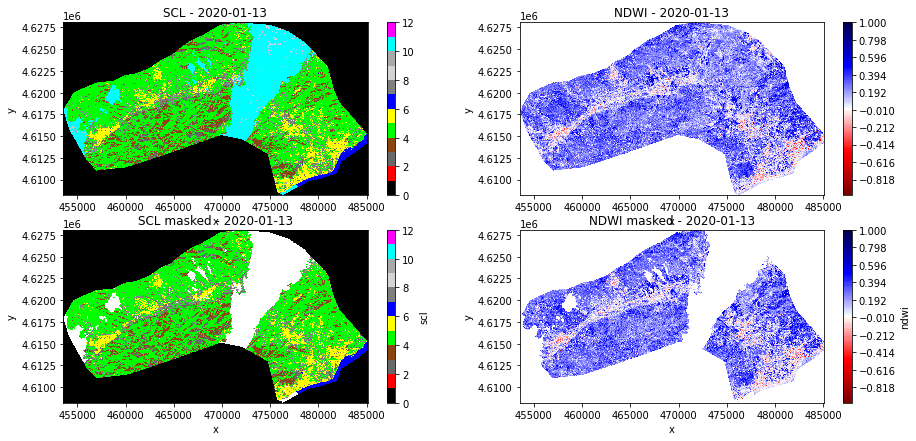

In [7]:
scl = rioxarray.open_rasterio("./sentinel2/out/SCL_10/S2B2A_20200113_008_tordera_SCL_10.tif", masked=True)
ndwi = rioxarray.open_rasterio("./sentinel2/indices/NDWI/S2B2A_20200113_008_tordera_NDWI_10.tif", masked=True)


dummy_ds = xr.Dataset({"scl" : scl, "ndwi" : ndwi})

scl_masked = dummy_ds["scl"].where(
                        (dummy_ds["scl"] != 8) & # dark_area
                        (dummy_ds["scl"] != 9) & # vegetation
                        (dummy_ds["scl"] != 10)  # not_vegetated
                      )

ndwi_masked = dummy_ds["ndwi"].where(
                        (dummy_ds["scl"] != 8) & # dark_area
                        (dummy_ds["scl"] != 9) & # vegetation
                        (dummy_ds["scl"] != 10)  # not_vegetated
                      )



fig, axs = plt.subplots(2,2, figsize = (15,7))

scl.plot(ax = axs[0,0], colors = scl_colors, levels = bounds_scl)
axs[0,0].title.set_text("SCL - 2020-01-13")

scl_masked.plot(ax = axs[1,0],  colors = scl_colors, levels = bounds_scl)
axs[1,0].title.set_text("SCL masked - 2020-01-13")

ndwi.plot(ax = axs[0,1], colors = ndwi_colormap, levels = ndwi_bounds)
axs[0,1].title.set_text("NDWI - 2020-01-13")

ndwi_masked.plot(ax = axs[1,1], colors = ndwi_colormap, levels = ndwi_bounds)
axs[1,1].title.set_text("NDWI masked - 2020-01-13")


plt.show()

The `SCL masked-2020-01-13` image reveals the issue for the clouds. To build a complete composite of the basin we need to stack lots of images, filling the gaps.

In [8]:
ndwi_dir = "./sentinel2/indices/NDWI/"


scl_files = [join(scl_dir_10, f) for f in listdir(scl_dir_10) if isfile(join(scl_dir_10, f))]
scl_files_dates = [S2_getDate(f).strftime("%Y-%m-%d") for f in scl_files]
scl_files_xarray = [rioxarray.open_rasterio(f, masked = True) for f in scl_files]

ndwi_files = [join(ndwi_dir, f) for f in listdir(ndwi_dir) if isfile(join(ndwi_dir, f))]
ndwi_files_dates = [S2_getDate(f).strftime("%Y-%m-%d") for f in ndwi_files]
ndwi_files_xarray = [rioxarray.open_rasterio(f, masked = True) for f in ndwi_files]


scl_dict = dict(zip(scl_files_dates, scl_files_xarray))
ndwi_dict = dict(zip(ndwi_files_dates, ndwi_files_xarray))

scl_ds = xr.Dataset(scl_dict)
ndwi_ds = xr.Dataset(ndwi_dict)

In [9]:
ndwi_masked_dict = dict()
for date in scl_files_dates : 
    
    d1 = xr.Dataset(data_vars = {
    "ndwi" : ndwi_ds[date],
    "scl"  : scl_ds[date]
    })

    ndwi_masked_dict[date] = d1["ndwi"].where(
                                 (d1["scl"] != 8) & # dark_area
                                 (d1["scl"] != 9) & # vegetation
                                 (d1["scl"] != 10)  # not_vegetated
    )
    
ndwi_ds_masked = xr.Dataset(ndwi_masked_dict)
ndwi_ds_masked

<xarray.Dataset>
Dimensions:      (band: 1, x: 3155, y: 1990)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.535e+05 4.536e+05 ... 4.851e+05 4.851e+05
  * y            (y) float64 4.628e+06 4.628e+06 ... 4.608e+06 4.608e+06
    spatial_ref  int64 0
Data variables: (12/15)
    2020-01-08   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2019-12-24   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2020-01-13   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2020-01-18   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2020-02-02   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2019-12-29   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    ...           ...
    2019-12-19   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2019-12-04   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2020-02-12   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2020-01-28   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2020-02-07   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    2020-01-23   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [10]:
reduced = ndwi_ds_masked.reduce(ndwi_ds_masked['2020-01-08'].combine_first) 
reduced = reduced.reindex(y = reduced.y[::-1])
reduced = reduced.assign_coords(x = ndwi_ds_masked.x,
                                y = ndwi_ds_masked.y)

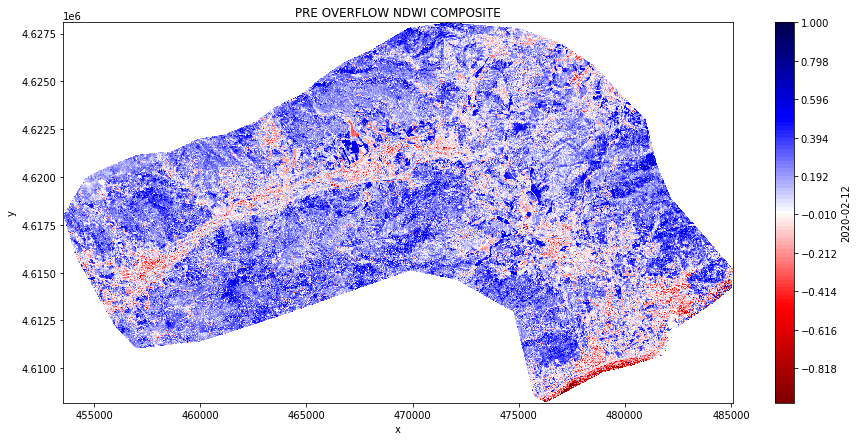

In [11]:
fig, axs = plt.subplots(1,1, figsize = (15,7))
reduced['2020-02-12'].plot(colors = ndwi_colormap, levels = ndwi_bounds)
axs.title.set_text("PRE OVERFLOW NDWI COMPOSITE")

## 2.2 - The post overflow image 

In [12]:
! ls -l ./sentinel2/out/SCL_10/

total 367920
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2A2A_20191209_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2A2A_20191219_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2A2A_20191229_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2A2A_20200108_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2A2A_20200118_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2A2A_20200128_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2A2A_20200207_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2B2A_20191204_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2B2A_20191214_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2B2A_20191224_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2B2A_20200103_008_tordera_SCL_10.tif
-rw-rw-r-- 1 vyago vyago 25126100 jun 30 01:57 S2B2A

In [ ]:
post_overflow_files = [
   "./sentinel2/out/SCL_10/S2A2A_20200128_008_tordera_SCL_10.tif",
   "./sentinel2/out/SCL_10/S2B2A_20200202_008_tordera_SCL_10.tif",
   "./sentinel2/out/SCL_10/S2A2A_20200207_008_tordera_SCL_10.tif",
   "./sentinel2/out/SCL_10/S2B2A_20200212_008_tordera_SCL_10.tif",
]

ncol = 2
nrow = len(post_overflow_files)//2

fig, axes = plt.subplots(nrow, ncol, figsize=(20,4*nrow),
                         sharex = True,
                         sharey = True,
                         constrained_layout = False)

for idx, ax in enumerate(np.ravel(axes)) : 
    try : 
        scl = rioxarray.open_rasterio(post_overflow_files[idx])
        scl.plot(ax=ax, colors = scl_colors, levels = bounds_scl)
        ax.title.set_text("SCL masked - %s" % S2_getDate(post_overflow_files[idx]) )

        
    except Exception as e :
        print("An error occurred while reading data for file %s " % post_overflow_files[idx])
        print("Original message: %s " % e)
    

In [ ]:
overflow_scl = rioxarray.open_rasterio("./sentinel2/out/SCL_10/S2B2A_20200202_008_tordera_SCL_10.tif", masked=True)
overflow_ndwi = rioxarray.open_rasterio("./sentinel2/indices/NDWI/S2B2A_20200202_008_tordera_NDWI_10.tif", masked=True)
overflow_ds = xr.Dataset({"scl" : overflow_scl, "ndwi" : overflow_ndwi})

overflow_ndwi_masked = overflow_ds["ndwi"].where(
                        (overflow_ds["scl"] != 8) & # dark_area
                        (overflow_ds["scl"] != 9) & # vegetation
                        (overflow_ds["scl"] != 10)  # not_vegetated
                      ) 

fig, axs = plt.subplots(1,1, figsize = (15,7))
overflow_ndwi_masked.plot(ax = axs, colors = ndwi_colormap, levels = ndwi_bounds)
axs.title.set_text("SCL 2022-02-02 - POST OVERFLOW - MASKED")

plt.show()

# 3 - Computing the overflow

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (20,5))

diff = reduced['2020-02-12'] - overflow_ndwi_masked
diff.where(diff < 0).plot(ax = axs[0])
diff.where(diff < 0).plot.hist(ax = axs[1])
plt.show()

In [ ]:
threshold = -0.1
fig, axs = plt.subplots(1,1, figsize = (15,7))
diff.where(diff < threshold).plot()
plt.show()

## 3.1 -  Overflowed area

In [ ]:
data = diff.where(diff < threshold).values
km_sq = (np.count_nonzero(~np.isnan(data))*10)/1e6
print("Approx overflowed area: %0.2f km^2" % km_sq)

## 3.1 - Affected population